In [1]:
from word2vec import *

import os

import torch
from sklearn.cluster import HDBSCAN

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('white')

In [3]:
word2vec = torch.load('word2vec.pth', map_location=DEVICE)

# Results

In [4]:
with open(TEST_FILE) as file:
    test_samples = [
        line for line in map(lambda t: t.split(), file.readlines())
        if all(map(lambda word: word in word2vec.vocabulary, line))
    ]

In [5]:
top5_accuracy, _ = test(word2vec, test_samples)
top5_accuracy

0.04370034052213394

# Clustering

In [6]:
norms = torch.linalg.vector_norm(word2vec.weight, dim=1)
dist_matrix = 1 - torch.mm(word2vec.weight, word2vec.weight.T) / torch.outer(norms, norms)

In [7]:
clustering = HDBSCAN(min_cluster_size=4,
                     min_samples=1,
                     cluster_selection_epsilon=0.2,
                     max_cluster_size=600,
                     metric='precomputed').fit(dist_matrix.cpu())

In [8]:
labels = sorted(set(clustering.labels_))
palette = dict(zip(labels, ['white'] + sns.color_palette('husl', len(labels) - 1).as_hex()))
colors_mapping = {word: palette[label] for word, label in zip(word2vec.vocabulary.get_itos(), clustering.labels_)}

In [9]:
tsne_viz, _ = tsne(word2vec, colors_mapping=colors_mapping)
tsne_viz.savefig(os.path.join(EXTRA_DIR, 'cloud.svg'))

# Playground

In [10]:
word2vec.nearest(word2vec('one'), 5)[0::2]

(['one', '1', 'version', 'ones', 'unit'],
 tensor([1.0000, 0.5466, 0.4214, 0.4150, 0.3797], device='cuda:0'))

In [11]:
word2vec.nearest(word2vec('mom'), 5)[0::2]

(['mom', 'girlfriend', 'mother', 'sister', 'wife'],
 tensor([1.0000, 0.8124, 0.8102, 0.7857, 0.7845], device='cuda:0'))

In [12]:
word2vec.nearest(word2vec('dad'), 5)[0::2]

(['dad', 'boyfriend', 'fiance', 'nephew', 'husband'],
 tensor([1.0000, 0.8766, 0.8614, 0.8599, 0.8499], device='cuda:0'))

In [13]:
samples = (
    *word2vec.nearest(word2vec('love'), 2)[0], 
    *word2vec.nearest(word2vec('trash'), 2)[0],
    *word2vec.nearest(word2vec('black'), 2)[0],
)

In [14]:
vectors = word2vec(samples)
norms = torch.linalg.vector_norm(vectors, dim=1)
similarity_matrix = torch.mm(vectors, vectors.T) / torch.outer(norms, norms)

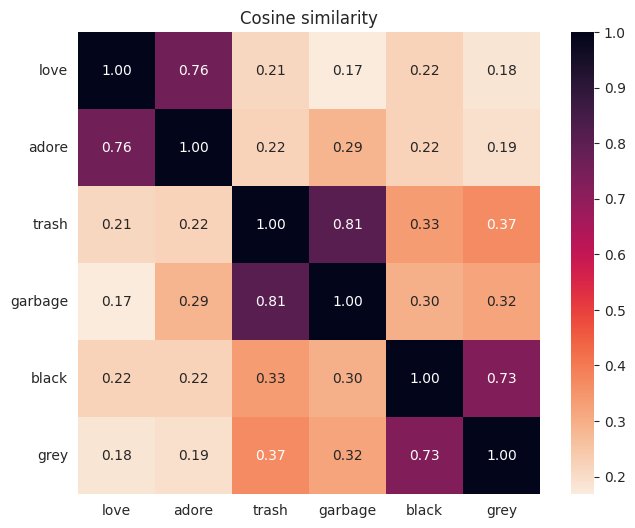

In [15]:
_, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    data=similarity_matrix.cpu(),
    square=True,
    annot=True,
    fmt='.02f',
    cmap=sns.cm.rocket_r,
    ax=ax,
)

ax.set_xticklabels(samples)
ax.set_yticklabels(samples, rotation=0)
_ = ax.set_title('Cosine similarity')